In [4]:
%reload_ext autoreload
%autoreload 3

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('text', usetex=False)
# mpl.rc('font', family='DejaVuSans', size=12)

import numpy as np
from IPython.display import display

import torch
import torchmetrics
import pytorch_lightning as pl
import pandas as pd
from src.cogponder import CogPonderModel
from src.cogponder.data import StroopSRODataset, CogPonderDataModule, NBackSRODataset
from pathlib import Path

from tqdm import tqdm

In [5]:
# Load checkpoint and data

ckpt_path = Path('models/checkpoints/stroop/cogponder_5subjects_3000epochs.ckpt')
model_ckpt = CogPonderModel.load_from_checkpoint(ckpt_path).to('cpu')

print('loading data module... ', end='')
dataset = StroopSRODataset(n_subjects=5,
                           step_duration=10,
                           shuffle_subjects=False,
                           non_decision_time='auto')
datamodule = CogPonderDataModule(dataset, num_workers=8)
datamodule.prepare_data()

subject_ids, trial_ids, contexts, stimuli, y_human, rt_human, y_correct = datamodule.test_dataset[:]
print('Done.')

human_stats = pd.DataFrame({
    'condition': dataset.inverse_transform_context(contexts),
    'subject': subject_ids,
    'response_time': rt_human * dataset.step_duration,
    'accuracy': (y_human == y_correct).float() * 100,
    'agent': 'Human',
})

loading data module... Done.


In [6]:

with torch.no_grad():
    model_ckpt.eval()

    # rt_preds = []
    # we run 10 test runs to get a better estimate of the RT
    # for i in tqdm(range(1)):
    y_pred, ctxt_preds, y_steps, p_halts, rt_pred = model_ckpt(stimuli, subject_ids)
    # rt_preds.append(rt_pred.numpy())

    # rt_preds = np.array(rt_preds)

# rt_pred = rt_preds.mean(axis=0)

cogpo_stats = pd.DataFrame({
    'condition': dataset.inverse_transform_context(contexts),
    'subject': subject_ids,
    'response_time': (rt_pred * dataset.step_duration),
    'accuracy': (y_pred == y_correct).float() * 100,
    'agent': 'CogPonder',
})

In [23]:
stats = pd.concat([human_stats, cogpo_stats]).reset_index()
stats['response_time'] = stats['response_time'] / 1000

plot_data = stats.melt(
    id_vars=['condition', 'agent'],
    value_vars=['response_time', 'accuracy'],
    var_name='measure'
)


In [ ]:
# Figure 4

# TODO: use the original plot data
# TODO: use sec instead of ms
# TODO: update x-axis labels (from dataset context)


g = sns.displot(
    data=stats, x='response_time', hue='condition',col='agent',
    kind='hist', kde=True, fill=True, common_norm=False,
    lw=0, alpha=.5, height=3, aspect=2,
    kde_kws={'cut': 0, 'clip': (0, 2000)},
    line_kws={'linewidth': 2},
    palette='Set2',
    legend=True
)

# replace labels
g._legend.set_title('Stroop')
g.legend.set_bbox_to_anchor((0.8, .7))
# for t, l in zip(g._legend.texts, ['Human', 'CogPonder']):
#     t.set_text(l)

g._legend.legend_handles[0].set_alpha(1)
g._legend.legend_handles[1].set_alpha(1)

# g.ax.set(yticks=[0, 5, 10, 15])

# g.ax.set(xlabel='Response Time (ms)', ylabel='# of trials')

plt.show()

<Axes: xlabel='agent', ylabel='value'>

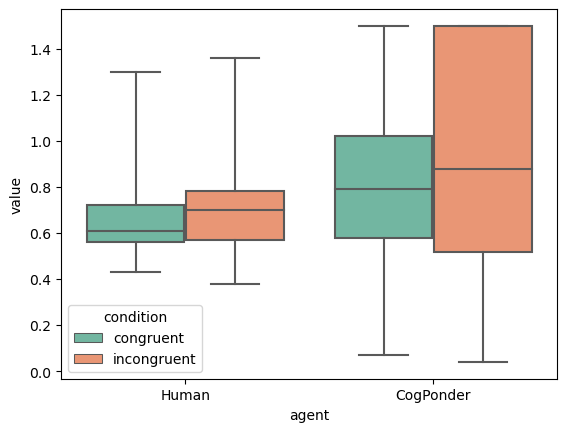

In [25]:
sns.boxplot(data=plot_data.query('measure == "response_time"'),
            x='agent', y='value', hue='condition',
            whis=10,
            palette='Set2')

/opt/conda/envs/cogponder/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


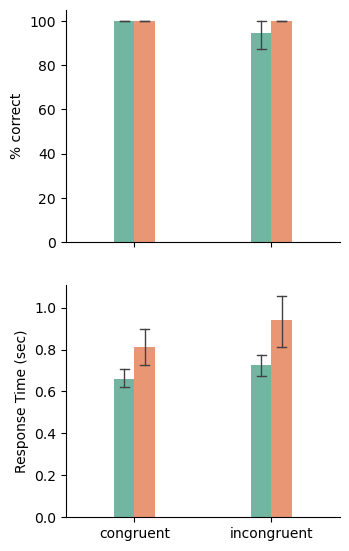

In [43]:
g = sns.catplot(
    data=plot_data, x='condition', y='value', row='measure', hue='agent',
    kind="bar", height=3, aspect=1.2,
    width=.3, errorbar=('ci', 95), capsize=.065, errwidth=1,
    palette='Set2',
    sharex=True, sharey=False,
    legend=False,
    row_order=['accuracy', 'response_time'],
    order=['congruent', 'incongruent'],
)

# g.add_legend(loc='upper left', bbox_to_anchor=(.3, 1))

g.axes[0,0].set_ylabel('% correct')
g.axes[1,0].set_ylabel('Response Time (sec)')
g.axes[0,0].set_title(None)
g.axes[1,0].set_title(None)
g.axes[0,0].set_xlabel(None)
g.axes[1,0].set_xlabel(None)

# plt.suptitle('Comparing human and CogPonder performance in the Stroop task', y=1.1)
plt.savefig('outputs/figures/figure3-stroop.png', bbox_inches='tight', dpi=300)
plt.show()

/opt/conda/envs/cogponder/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_71115/1990662112.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


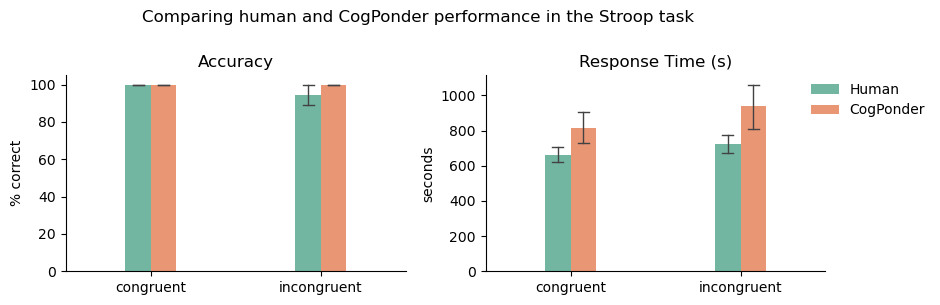

In [11]:
g = sns.catplot(
    data=plot_data, x='condition', y='value', col='measure', hue='agent',
    kind="bar", height=3, aspect=1.2,
    width=.3, errorbar=('ci', 95), capsize=.065, errwidth=1,
    palette='Set2',
    sharex=False, sharey=False,
    estimator='mean',
    col_order=['accuracy', 'response_time'],
    legend=False
)

g.add_legend(loc='upper left', bbox_to_anchor=(.95, .8))

g.axes[0,0].set_ylabel('% correct')
g.axes[0,0].set_title('Accuracy')
g.axes[0,1].set_ylabel('seconds')
g.axes[0,1].set_title('Response Time (s)')
g.axes[0,0].set_xlabel(None)
g.axes[0,1].set_xlabel(None)


plt.suptitle('Comparing human and CogPonder performance in the Stroop task', y=1)
plt.tight_layout()
plt.savefig('outputs/figures/figure3-stroop.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# Figure 4

plot_data = stats[['condition', 'agent', 'response_time', 'accuracy']]
plot_data = plot_data.query('response_time < 1500')

g = sns.displot(
    data=plot_data, x='response_time', hue='condition', col='agent',
    kind='hist', kde=True, fill=True,
    lw=0, alpha=.5, height=3, aspect=1.5,
    kde_kws={'cut': 0, 'clip': (0, 2000)},
    line_kws={'linewidth': 2},
    facet_kws=dict(sharey=False),
    palette=sns.color_palette(['deepskyblue', 'orangered'], 2),
)

g.set(xlabel='Response time (ms)', ylabel='trials')
g.legend.set_title(None)
g.legend.set_bbox_to_anchor((.45, .5))

# plt.suptitle('Comparing human (N=1) and CogPonder response time distributions in the Stroop task')
# plt.tight_layout()
plt.savefig('outputs/figures/figure4-stroop.png', bbox_inches='tight', dpi=300)

[Text(0.5, 0, 'Median response time (ms)'),
 Text(0, 0.5, 'Standard deviation (ms)')]

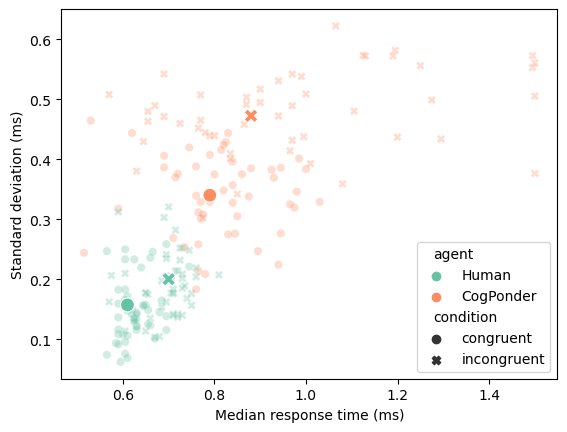

In [44]:

# sns.relplot(
#     data=plot_data, x='response_time', y='response_time', hue='condition',
#     style='agent',
# )


def boot_ci(x):

    res = []
    for _ in range(50):
        x_sample = x.sample(10)
        mean = x_sample.mean().item()
        medi = x_sample.median().item()
        sd = x_sample.std().item()
        res.append([mean, medi, sd])
    return res
    # return torchmetrics.functional.bootstrapped_ci(x, alpha=.05, num_samples=1000)

plot_data = stats[['condition', 'agent', 'response_time', 'accuracy']]
# plot_data = plot_data.query('response_time < 1500')
xx = plot_data.groupby(['condition', 'agent'])['response_time'].apply(boot_ci).apply(pd.Series)
xx = xx.reset_index().melt(id_vars=['condition', 'agent'])
xx[['mean','median', 'sd']] = xx['value'].apply(pd.Series)

sns.scatterplot(data=xx, x='median', y='sd', hue='agent', style='condition',
                alpha=.3,
                hue_order=['Human', 'CogPonder'],
                palette='Set2')

x = plot_data.groupby(['condition', 'agent']).apply('median')
y = plot_data.groupby(['condition', 'agent']).apply('std')

# sns.scatterplot(x=x.values, y=y, hue='condition', style='agent')
xy = pd.merge(x, y, on=['condition', 'agent'], suffixes=('_median', '_std'))

sns.scatterplot(data=xy, x='response_time_median', y='response_time_std', hue='agent', 
                hue_order=['Human', 'CogPonder'],
                style='condition', legend=False, palette='Set2', alpha=1, s=100)

plt.gca().set(xlabel='Median response time (ms)', ylabel='Standard deviation (ms)')

# sns.histplot(data=xx, x='mean', y='median', bins=50, pthresh=.1, cmap="mako")
# sns.kdeplot(data=xx, x='mean', y='median', hue='condition', levels=2, linewidths=1)

In [14]:
xy

response_time_median  accuracy_median  \
condition   agent                                              
congruent   CogPonder                 770.0            100.0   
            Human                     610.0            100.0   
incongruent CogPonder                 660.0            100.0   
            Human                     700.0            100.0   

                       response_time_std  accuracy_std  
condition   agent                                       
congruent   CogPonder         292.850091      0.000000  
            Human             157.392602      0.000000  
incongruent CogPonder         347.575951      0.000000  
            Human             200.450062     22.720778

In [15]:
# sns.scatterplot(data=plot_data, x='accuracy', y='response_time', hue='agent', style='condition', palette='Set2')
plot_data.shape

(205, 4)